# Задача проекта - прогнозирование ежемесячной выручки ресторанов

Необходимо научиться на основе модели линейной регрессии прогнозировать месячную выручку ресторанов


## Описание данных

### Обозначения признаков


Набор данных содержит следующие сведения:

* `Number_of_Customers` - количество посетителей ресторана
* `Menu_Price` - средние цены на меню в ресторане
* `Marketing_Spend` - расходы на маркетинговую деятельность
* `Cuisine_Type` - тип предлагаемой кухни (итальянская, мексиканская, японская, американская).
* `Average_Customer_Spending` - средние расходы на одного клиента
* `Promotions` - бинарный индикатор (0 или 1), указывающий, проводились ли рекламные акции
* `Reviews` - количество отзывов, полученных рестораном
* `Monthly_Revenue` - ежемесячный доход ресторана, целевая переменная для прогнозирования

## Подготовка и предварительный анализ данных

In [ ]:
# Загрузим необходимые библиотеки и инструменты
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import statsmodels.api as sm
from scipy import stats as st

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# игнорируем предупреждения
import warnings
warnings.filterwarnings(action='ignore')

Обычно данные хранятся в файле, которую нужно привести к виду таблицы.
Чаще всего вы будете работать с файлами `.csv` (англ. `Comma-Separated Values`, «значения, разделённые запятой»). Часто такие файлы с данными называют датасетами.

Для чтения файла используют метод `read_csv()`. В качестве аргумента он принимает путь к файлу. Путь к файлу — строка с именем файла и каталогами, в которые он вложен.

Например, прочитаем файл `file_name.csv` и перенесем данные из файла в датафрейм с именем `df`:

`df = pd.read_csv('/file_name.csv')`.

In [ ]:
# Прочитаем файлы с данными и изучим их

try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/Restaurant_revenue.csv')
except:
    df = pd.read_csv('Restaurant_revenue.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Для того, чтобы выводить не весь DataFrame, а только часть, можно использовать следующие приемы:

* Вывод первых 5 строк - `df.head()`
* Вывод последних 5 строк - `df.tail()`
* Вывод 5 случайных строк - `df.sample(5)`

Полезные методы, которые вы можете использовать, для того, чтобы посмотреть на размер данных, названия признаков и их типы:

* `df.shape` - показывает размер датафрейма

* `df.columns` - показывает названия признаков (столбцов)

* `df.dtypes` - показывает информацию о типах данных

* `df.info()` - показывает информацию о наборе данных, индекс, столбцы и тип данных, ненулевые значения и использование памяти.

* `df.describe()` - показывает количество строк в столбце, среднее значение столбца, столбец стандартное отклонение , минимальные (min) и максимальные (max) значения, а также границу каждого квартиля - 25%, 50% и 75%. Любые значения `NaN` автоматически пропускаются. По умолчанию, метод `describe( )` пропускает строки и столбцы не содержащие чисел - категориальные признаки. Чтобы посмотреть статистику по нечисловым признакам, нужно явно указать интересующие нас типы в параметре `include`. Можно также задать `include = 'all'`, чтоб вывести статистику по всем имеющимся признакам.


Для обнаружения недостающих данных используют методы `isnull()` и `notnull()`.

Результатом является логическое значение, указывающее, действительно ли значение, переданное в аргумент, отсутствует. «Истина» означает, что значение является отсутствующим значением, а «Ложь» означает, что значение не является отсутствующим.

Сумма значений находится методом `sum()`.

Например, `df.isnull().sum()` сформирует сводную таблицу с названием столбца таблицы и количеством пропущенных записей в этом столбце.

Для обнаружения явных дубликатов используют метод `duplicated()`.


Результатом является логическое значение, указывающее, действительно ли значение, переданное в аргумент, отсутствует. «Истина» означает, что значение является отсутствующим значением, а «Ложь» означает, что значение не является отсутствующим.

Сумма значений находится методом `sum()`.

Например, `df.duplicated().sum()` определит общее количество дублирующих записей во всем датасете.

Изучим датасет.

Сначала изучим общую информацию о данных и устраним проблемы в данных, если они будут обнаружены (пропуски, дубликаты, несоответствие типов данных).

In [ ]:
# Первые 5 строк датасета
df.head()

Number_of_Customers  Menu_Price  Marketing_Spend Cuisine_Type  \
0                   61   43.117635        12.663793     Japanese   
1                   24   40.020077         4.577892      Italian   
2                   81   41.981485         4.652911     Japanese   
3                   70   43.005307         4.416053      Italian   
4                   30   17.456199         3.475052      Italian   

   Average_Customer_Spending  Promotions  Reviews  Monthly_Revenue  
0                  36.236133           0       45       350.912040  
1                  17.952562           0       36       221.319091  
2                  22.600420           1       91       326.529763  
3                  18.984098           1       59       348.190573  
4                  12.766143           1       30       185.009121

In [ ]:
# Общая информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Number_of_Customers        1000 non-null   int64  
 1   Menu_Price                 1000 non-null   float64
 2   Marketing_Spend            1000 non-null   float64
 3   Cuisine_Type               1000 non-null   object 
 4   Average_Customer_Spending  1000 non-null   float64
 5   Promotions                 1000 non-null   int64  
 6   Reviews                    1000 non-null   int64  
 7   Monthly_Revenue            1000 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 62.6+ KB


In [ ]:
# Количество пропусков
df.isnull().sum()

Number_of_Customers          0
Menu_Price                   0
Marketing_Spend              0
Cuisine_Type                 0
Average_Customer_Spending    0
Promotions                   0
Reviews                      0
Monthly_Revenue              0
dtype: int64

In [ ]:
# Колиичество дубликатов
df.duplicated().sum()

0

В датасете с информацией пропущенных значений и дубликатов нет. Все данные имеют нужные типы.

## Исследовательский и статистический анализ данных

### Оценка заведений по типам кухни

Определим все уникальные записи в столбце `Cuisine_Type`.

Определим, какой тип кухни предлагают рестораны и вычислим количество ресторанов каждого вида кухни. Для этого используем метод `value_counts`, который выполняет группировку данных по указанному столбцу и подсчитывает количество записей каждого значения. Если в качестве параметра указать `normalize=True`, то метод произведет вычисление значений с долевом отношении.

In [ ]:
#та же информация, но в долевом выражении
df_type=df['Cuisine_Type'].value_counts(normalize=True)

Видим, что примерно одинаковое количество ресторанов в каждой группе.

Для визуального представления числа записей каждого класса можно построить столбиковую диаграмму методом `countplot` из библиотеки `seaborn` или круговую диаграмму методом `pie` из библиотеки `seaborn`.

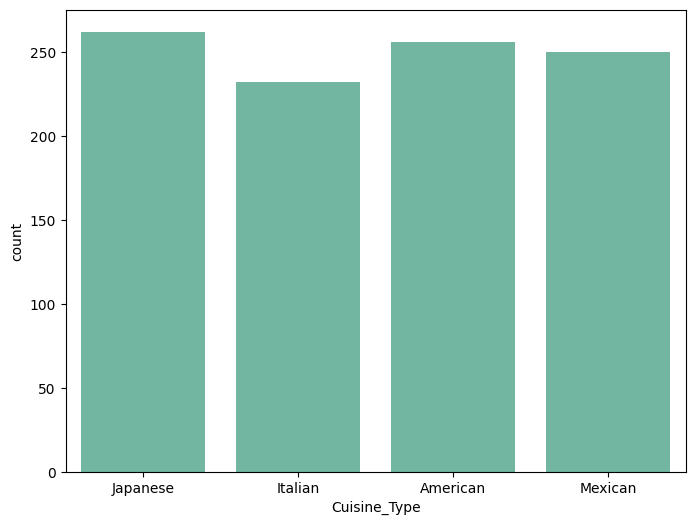

In [ ]:
# Столбиковая диаграмма количества ресторанов по типам кухни
sns.set_palette('Set2')
plt.figure(figsize=(8,6))
sns.countplot(x=df['Cuisine_Type'])


plt.show()

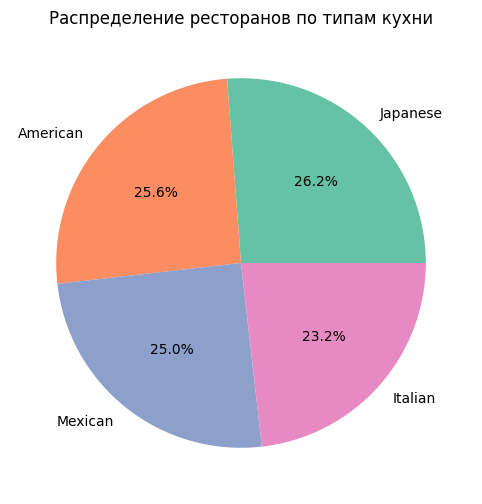

In [ ]:
# Круговая диаграмма в долевом соотношении ресторанов по типам кухни
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('Распределение ресторанов по типам кухни')

ax.pie(df_type.values,labels=df_type.index,autopct='%1.1f%%')
plt.show()

Видим, что количество ресторанов по типам кухни примерно одинаково.

Оценим, имеются ли различия в ресторанах с разной кухней по числу посетителей, среднему чеку и т.д. Для этого сгруппируем данные по типу кухни и найдем описательную статистику всех количественных показателей

Существенных различий количественные признаки не имеют.

Изучим попарные распределения признаков с помощью диаграмм рассеяния. Диаграммы рассеяния можно изобразить с помощью метода `pairplot`. Можем добавить третье измерений на диаграммы рассеяния в виде параметра `hue`.

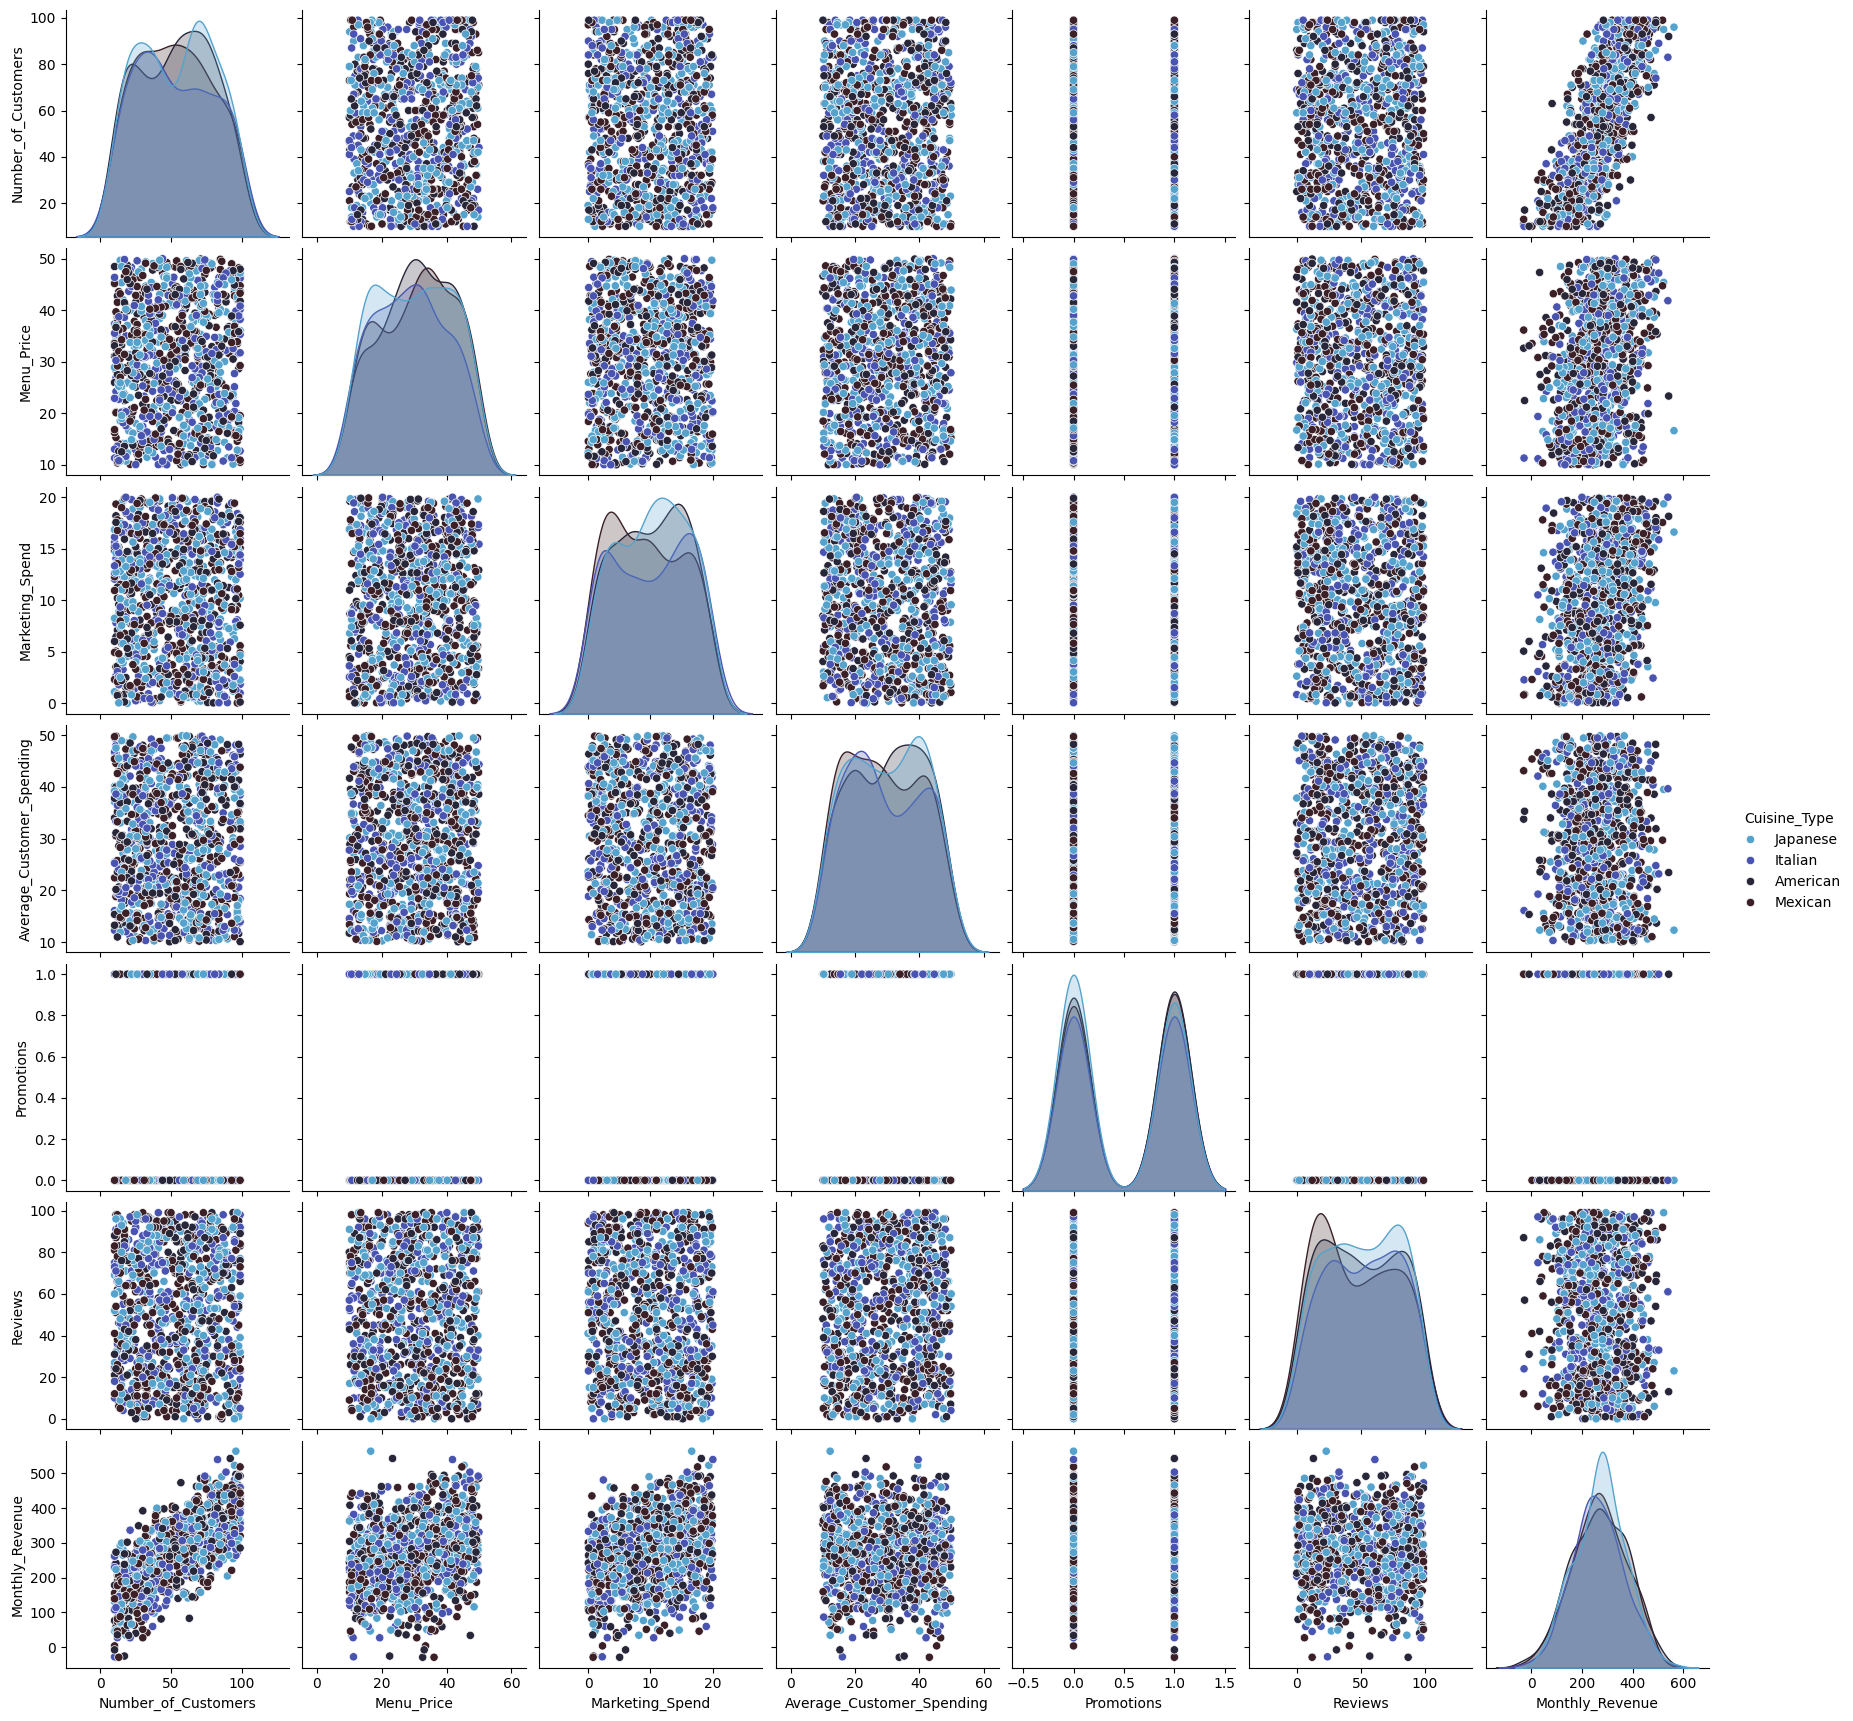

In [ ]:
sns.set_palette('icefire')
sns.pairplot(df,hue='Cuisine_Type')

plt.show()

In [ ]:
df.groupby('Cuisine_Type').describe().T

Cuisine_Type                       American     Italian    Japanese  \
Number_of_Customers       count  256.000000  232.000000  262.000000   
                          mean    53.445312   52.771552   53.973282   
                          std     26.013966   27.139761   26.441927   
                          min     10.000000   10.000000   10.000000   
                          25%     30.750000   30.000000   31.000000   
                          50%     55.000000   50.000000   59.000000   
                          75%     75.000000   75.250000   74.000000   
                          max     99.000000   99.000000   99.000000   
Menu_Price                count  256.000000  232.000000  262.000000   
                          mean    30.914943   28.922132   30.011624   
                          std     11.080613   11.072902   11.474605   
                          min     10.009501   10.013300   10.049467   
                          25%     22.566445   19.403808   19.751174   
                          50%     31.072958   29.119115   30.105804   
                          75%     40.708798   37.844512   40.063710   
                          max     49.907705   49.974140   49.685333   
Marketing_Spend           count  256.000000  232.000000  262.000000   
                          mean    10.089273   10.079843   10.305762   
                          std      5.649401    6.216160    5.623205   
                          min      0.042077    0.057625    0.003768   
                          25%      5.309099    3.939146    5.397813   
                          50%     10.517831   10.613080   10.635780   
                          75%     14.864521   15.804383   14.850008   
                          max     19.892973   19.994276   19.834852   
Average_Customer_Spending count  256.000000  232.000000  262.000000   
                          mean    30.071254   29.251461   29.784450   
                          std     11.367564   11.633264   11.445853   
                          min     10.037177   10.272588   10.205585   
                          25%     20.155670   19.699094   19.863438   
                          50%     30.792563   27.676848   30.290013   
                          75%     39.768225   39.560984   39.726435   
                          max     49.751359   49.820439   49.900725   
Promotions                count  256.000000  232.000000  262.000000   
                          mean     0.507812    0.500000    0.465649   
                          std      0.500918    0.501081    0.499773   
                          min      0.000000    0.000000    0.000000   
                          25%      0.000000    0.000000    0.000000   
                          50%      1.000000    0.500000    0.000000   
                          75%      1.000000    1.000000    1.000000   
                          max      1.000000    1.000000    1.000000   
Reviews                   count  256.000000  232.000000  262.000000   
                          mean    49.667969   51.823276   50.977099   
                          std     29.654532   28.375478   28.521543   
                          min      0.000000    0.000000    0.000000   
                          25%     23.500000   27.750000   27.000000   
                          50%     47.500000   54.500000   52.000000   
                          75%     76.000000   76.000000   76.750000   
                          max     99.000000   99.000000   99.000000   
Monthly_Revenue           count  256.000000  232.000000  262.000000   
                          mean   269.604825  263.699862  271.700186   
                          std    110.873108  100.384733   98.654120   
                          min    -28.977809  -27.610276   34.494211   
                          25%    187.561999  201.396843  204.959483   
                          50%    271.204821  260.005429  277.851879   
                          75%    354.424106  329.089894  335.752620   
                        

Видим, что большинство признаков имеют похожие распределения, но отличаются числовыми характеристиками. Для некоторых данных характерны смещения влево или вправо.



Построим гистограммы распределения месячной выручки ресторанов. Гистограмма распределения строится методом `histplot`.

Чтобы на одном графике эти сведения не сильно различались, построим гистограммы плотности распределения вероятностей, т.е. площать под графиком будет равна единице. Для этого в качестве параметра метода `histplot` необходимо указать `stat = 'density'`.

Чтобы на одном графике можно было наблюдать несколько гистограмм одновременно, необходимо добавить прозрачность этих графиков с помощью параметра `alpha`. Чем ближе его значение к 0, тем прозрачнее график.

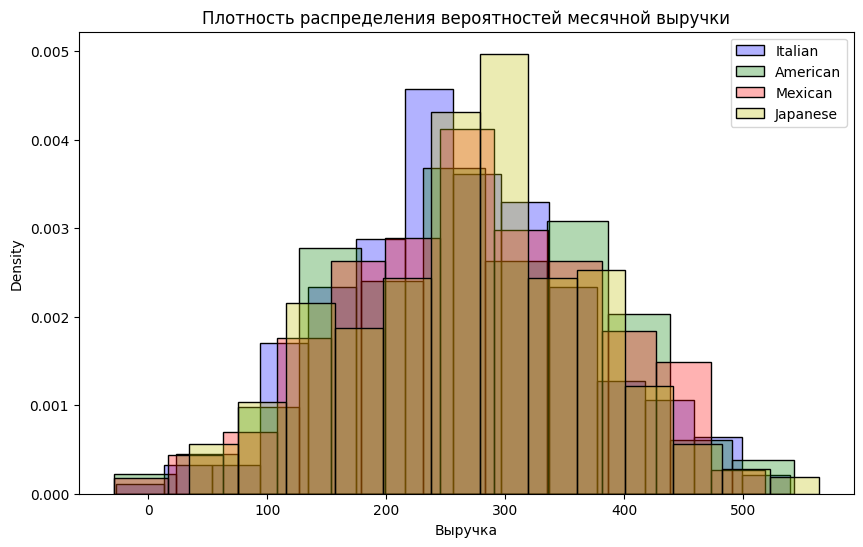

In [ ]:
plt.figure(figsize = (10,6))
sns.histplot(df.query('Cuisine_Type == "Italian"')['Monthly_Revenue'], stat = 'density', color = 'b', alpha = 0.3, label = 'Italian')
sns.histplot(df.query('Cuisine_Type == "American"')['Monthly_Revenue'], stat = 'density', color = 'g', alpha = 0.3, label = 'American')
sns.histplot(df.query('Cuisine_Type == "Mexican"')['Monthly_Revenue'], stat = 'density', color = 'r', alpha = 0.3, label = 'Mexican')
sns.histplot(df.query('Cuisine_Type == "Japanese"')['Monthly_Revenue'], stat = 'density', color = 'y', alpha = 0.3, label = 'Japanese')
plt.legend(loc = 'best')
plt.title('Плотность распределения вероятностей месячной выручки')
plt.xlabel('Выручка')
plt.show()

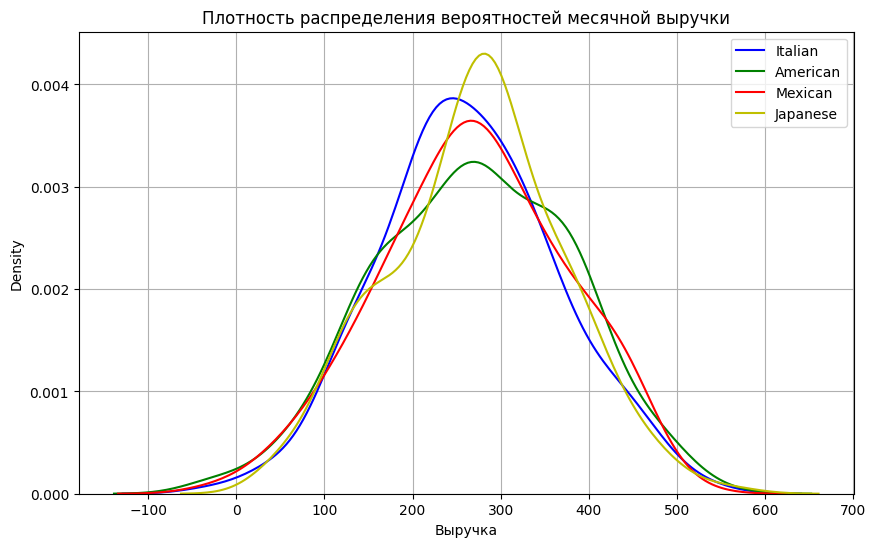

In [ ]:
plt.figure(figsize = (10,6))
sns.distplot(df.query('Cuisine_Type == "Italian"')['Monthly_Revenue'], hist = False, color = 'b', label = 'Italian')
sns.distplot(df.query('Cuisine_Type == "American"')['Monthly_Revenue'],  hist = False, color = 'g', label = 'American')
sns.distplot(df.query('Cuisine_Type == "Mexican"')['Monthly_Revenue'], hist = False, color = 'r', label = 'Mexican')
sns.distplot(df.query('Cuisine_Type == "Japanese"')['Monthly_Revenue'], hist = False, color = 'y', label = 'Japanese')

plt.legend(loc = 'best')
plt.title('Плотность распределения вероятностей месячной выручки')
plt.xlabel('Выручка')
plt.grid()
plt.show()

Построим графики плотности распределения всех числовых признаков ресторанов и оценим их распределения. Для построения гистограммы распределения можно использовать методы `histplot`, `distplot` или `kdeplot`.

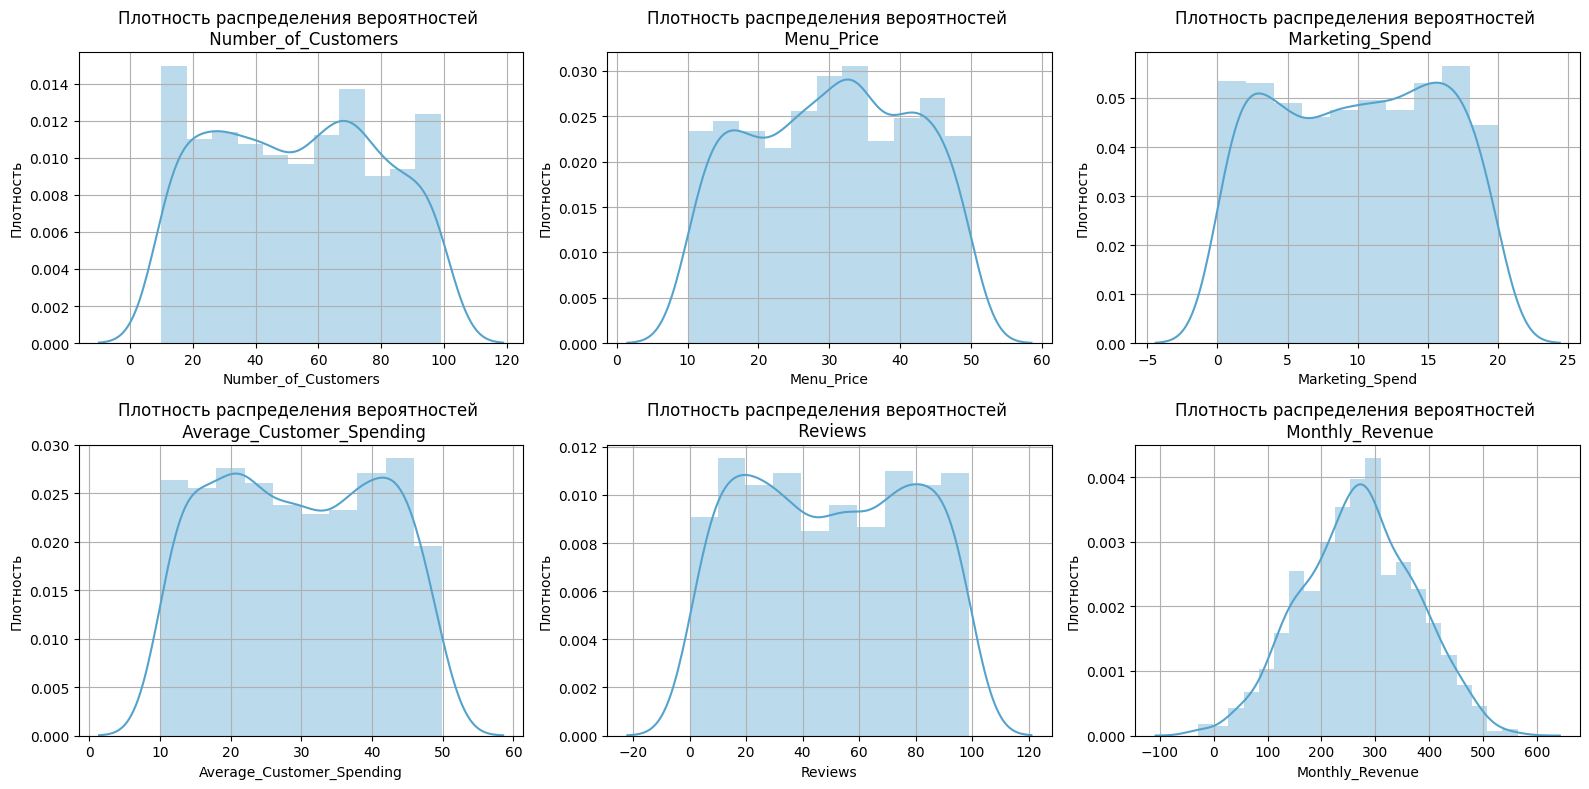

In [ ]:
# Построим графики плотности распределения количественных признаков
num_col = ['Number_of_Customers', 'Menu_Price', 'Marketing_Spend','Average_Customer_Spending', 'Reviews','Monthly_Revenue']
fig = plt.figure(figsize = (16,8))
for i, name in enumerate(num_col):
    axes = fig.add_subplot(2, 3, i+1)
    plt.title(f"Плотность распределения вероятностей \n {name}", fontsize=12)
    sns.distplot(df[name], hist=True,ax=axes)

    plt.grid()
    plt.xlabel(name, fontsize = 10)
    plt.ylabel('Плотность', fontsize = 10)
    plt.tight_layout()



Распределения всех признаков, кроме месячной выручки, похожи на равномерные. Проверим гипотезу о нормальном распределении признака `Monthly_Revenue`. Применим критерий Шапиро-Уилка. Его плюс в том, что при фиксированном уровне значимости он обладает бóльшей мощностью, чем хи-квадрат: чаще обнаруживает различия между распределениями, если они и правда есть.

In [ ]:
def stat_shapiro(data):
    alpha = 0.05  # критический уровень статистической значимости
    results = st.shapiro(data)
    p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value
    print("Alpha: ", alpha)
    print("P-value: {0:.3f}".format(p_value))
    if p_value < alpha:
        print('Нет оснований принять нулевую гипотезу: распределение не является нормальным')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу, распределение нормально')


In [ ]:
st.shapiro(df['Monthly_Revenue'])

ShapiroResult(statistic=0.9975600242614746, pvalue=0.14288349449634552)

In [ ]:
# Применим функцию stat_shapiro к столбцу Monthly_Revenue
stat_shapiro(df['Monthly_Revenue'])

Alpha:  0.05
P-value: 0.143
Нет оснований отвергнуть нулевую гипотезу, распределение нормально


Для оценки того, соответствует ли набор данных нормальному распределению, можно построить график `QQ` , сокращенно от «квантильный-квантильный».

На графике `QQ` ось X отображает теоретические квантили.Это означает, что он не показывает ваши фактические данные, а вместо этого показывает, где ваши данные были бы, если бы они были нормально распределены.

Ось Y отображает ваши фактические данные. Это означает, что если значения данных падают примерно по прямой линии под углом 45 градусов, то данные распределяются нормально.

Хотя график `QQ` не является формальным статистическим тестом, он предлагает простой способ визуально проверить, нормально ли распределен набор данных.

Чтобы создать график `QQ` для этого набора данных, мы можем использовать функцию `qqplot()` из библиотеки `statsmodels`

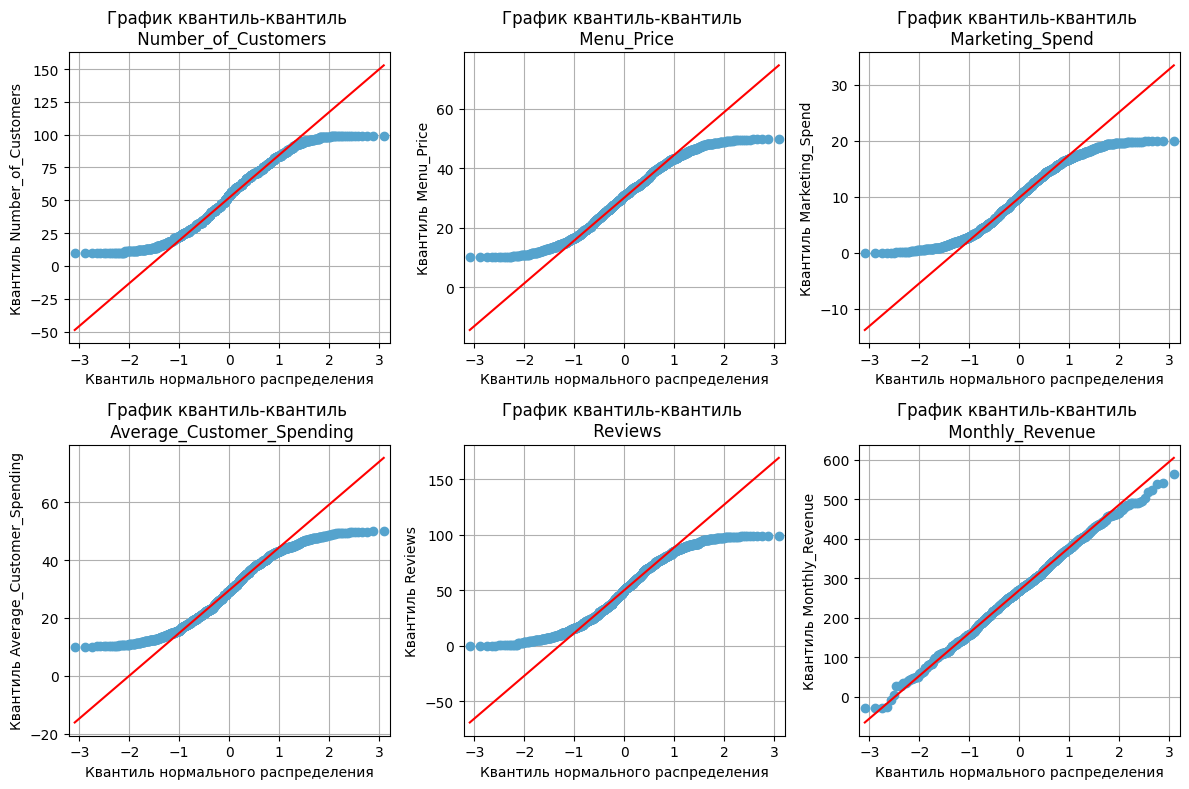

In [ ]:
# Построим графики QQ количественных признаков

fig = plt.figure(figsize = (12,8))
for i, name in enumerate(num_col):
    axes = fig.add_subplot(2, 3, i+1)
    plt.title(f"График квантиль-квантиль \n {name}", fontsize=12)
    sm.qqplot(df[name],line='q',ax=axes)

    plt.grid()
    plt.xlabel('Квантиль нормального распределения', fontsize = 10)
    plt.ylabel('Квантиль '+name, fontsize = 10)
    plt.tight_layout()


Мы можем видеть на нашем графике `QQ` для признака `Monthly_Revenue`, что значения данных имеют тенденцию близко следовать к 45-градусной прямой, что означает, что данные, вероятно, нормально распределены.

Оценим нетипичные значения числовых признаков по диаграммам размаха. Построим графики `boxplot`, `violinplot` или `stripplot`.

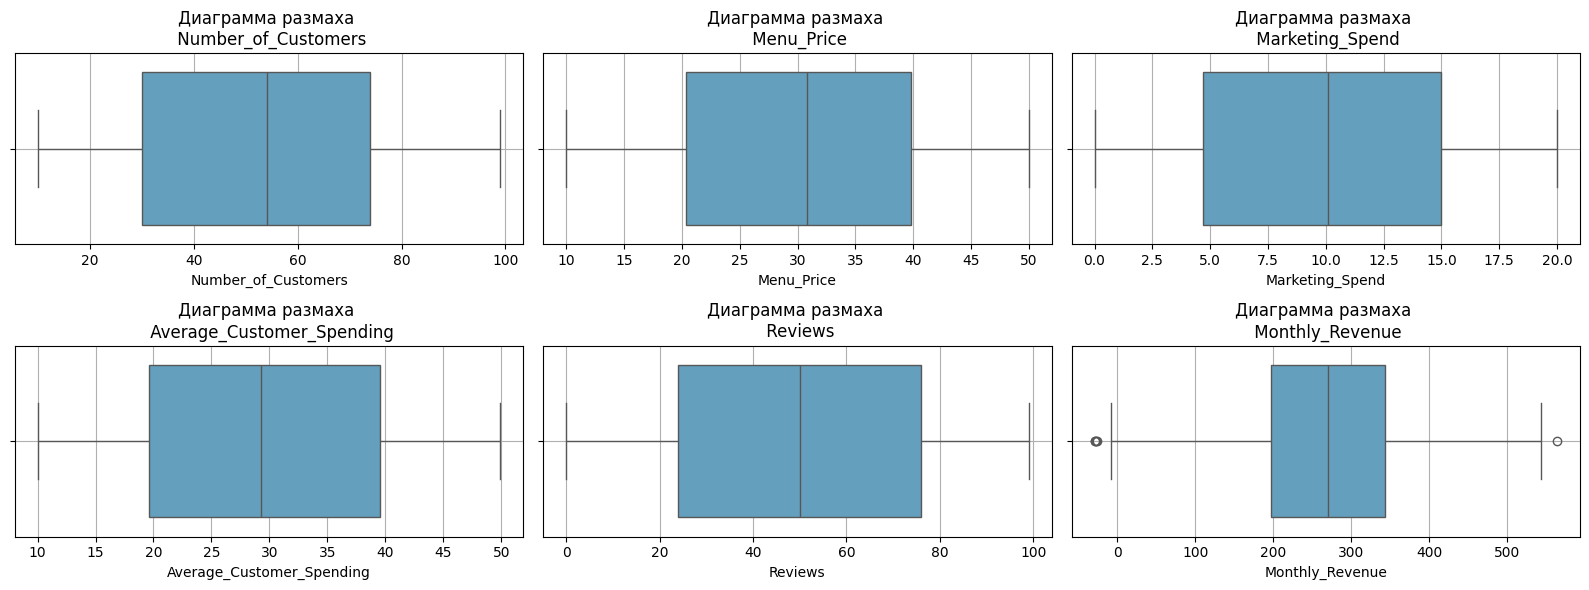

In [ ]:
# Построим диаграммы размаха методом boxplot

fig = plt.figure(figsize = (16,6))
for i, name in enumerate(num_col):
    axes = fig.add_subplot(2, 3, i+1)
    plt.title(f"Диаграмма размаха \n {name}", fontsize=12)
    sns.boxplot(x=df[name],ax=axes)

    plt.grid()
    plt.xlabel(name, fontsize = 10)
    plt.tight_layout()


Для значений месячной выручки видим небольшое количество нетипичных отрицательных значений. Изучим описательную статистику числовых признаков методом  `describe()`.

Заметные на гистограмме нюансы распределения хорошо бы зафиксировать в числах: иметь под рукой среднее, медиану, количество наблюдений в выборке и разброс их значений. Такие характеристики, дающие представление о выборке, входят в числовое описание данных. В `Python` его получают методом `describe()` (пер. «описать, охарактеризовать»). Результат работы метода — список характерных значений.

Правильно истолковать значения на диаграмме размаха трудно. Можно сравнить числовое описание, которое выдаёт метод `describe()`, с диаграммой размаха. Так вы графически отобразите распределение данных и зафиксируете важные значения в числах. Обратите внимание, что значения 25% и 75% в выдаче метода `describe()` — это `Q1` и `Q3` соответственно.

In [ ]:
df.describe(percentiles=[0.05,0.25,0.75,0.95])

Number_of_Customers   Menu_Price  Marketing_Spend  \
count          1000.000000  1000.000000      1000.000000   
mean             53.271000    30.219120         9.958726   
std              26.364914    11.278760         5.845586   
min              10.000000    10.009501         0.003768   
5%               13.000000    12.190907         0.882812   
25%              30.000000    20.396828         4.690724   
50%              54.000000    30.860614        10.092047   
75%              74.000000    39.843868        14.992436   
95%              96.000000    47.976615        18.962904   
max              99.000000    49.974140        19.994276   

       Average_Customer_Spending   Promotions      Reviews  Monthly_Revenue  
count                1000.000000  1000.000000  1000.000000      1000.000000  
mean                   29.477085     0.497000    49.837000       268.724172  
std                    11.471686     0.500241    29.226334       103.982950  
min                    10.037177     0.000000     0.000000       -28.977809  
5%                     12.095320     0.000000     6.000000       101.799445  
25%                    19.603041     0.000000    24.000000       197.103642  
50%                    29.251365     0.000000    50.000000       270.213964  
75%                    39.553220     1.000000    76.000000       343.395793  
95%                    47.300492     1.000000    95.000000       438.101569  
max                    49.900725     1.000000    99.000000       563.381332

Видим, что 5%-ный квартиль положительный, поэтому отрицательных значений месячной выручки менее 5%. Определим, границы выбросов.


In [ ]:
q_25=df['Monthly_Revenue'].quantile(0.25)
q_75=df['Monthly_Revenue'].quantile(0.75)
lower=q_25-1.5*(q_75-q_25)
upper=q_75+1.5*(q_75-q_25)
q_25, q_75,lower,upper

(197.10364179213317, 343.395792775241, -22.334584682528515, 562.8340192499027)

Видим, что нижняя граница выбросов месячной выручки отрицательная. Поэтому устраним все отрицательные записи и исключим данные за пределами верхней границы выбросов. Для этого сформируем срез методом `query` по условию `Monthly_Revenue >=0` и `Monthly_Revenue <= upper`. Заметим, что если при формировании среза используется внешняя переменная (здесь это значение `upper`), то при обращени к ней используем знак `@`.

In [ ]:
df_clear=df.query('Monthly_Revenue >=0 & Monthly_Revenue <=@upper')
df_clear.describe()

Number_of_Customers  Menu_Price  Marketing_Spend  \
count           994.000000  994.000000       994.000000   
mean             53.434608   30.248379         9.987001   
std              26.247184   11.283711         5.836555   
min              10.000000   10.009501         0.003768   
25%              31.000000   20.443839         4.704846   
50%              54.000000   30.860614        10.160257   
75%              74.000000   39.904905        14.995489   
max              99.000000   49.974140        19.994276   

       Average_Customer_Spending  Promotions     Reviews  Monthly_Revenue  
count                 994.000000  994.000000  994.000000       994.000000  
mean                   29.498219    0.494970   49.902414       269.898773  
std                    11.466233    0.500226   29.235191       101.774306  
min                    10.037177    0.000000    0.000000         3.819308  
25%                    19.676892    0.000000   24.000000       199.160139  
50%                    29.251365    0.000000   50.000000       270.527956  
75%                    39.560178    1.000000   76.000000       343.461651  
max                    49.900725    1.000000   99.000000       542.467282

In [ ]:
#Оценим числовые характеристики данных после устранения выбросов


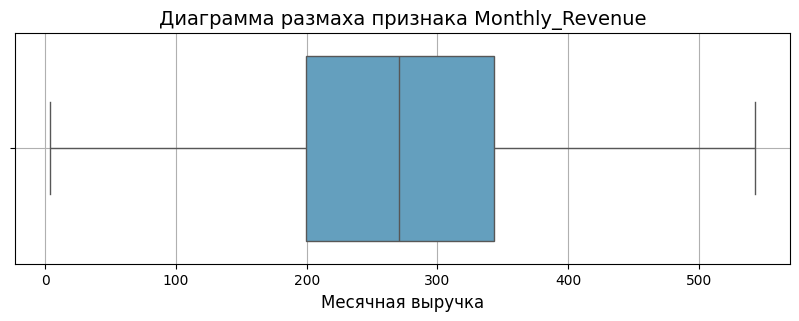

In [ ]:
# Построим диаграмму размаха для признака Monthly_Revenue

plt.figure(figsize = (10,3))
plt.title("Диаграмма размаха признака Monthly_Revenue", fontsize = 14)
sns.boxplot(x=df_clear['Monthly_Revenue'])

plt.grid()
plt.xlabel('Месячная выручка', fontsize = 12)
plt.show()

Все выбросы устранены.

### Изучение корреляционных связей

Построим матрицу парных коэффициентов корреляции методом `corr()`. Сохраним эти сведения в таблицу с именем `corr`.

In [ ]:
corr=df_clear[num_col].corr()
corr

Number_of_Customers  Menu_Price  Marketing_Spend  \
Number_of_Customers                   1.000000    0.033606        -0.018264   
Menu_Price                            0.033606    1.000000         0.015689   
Marketing_Spend                      -0.018264    0.015689         1.000000   
Average_Customer_Spending            -0.012444    0.017096        -0.056750   
Reviews                              -0.010887    0.001947        -0.032851   
Monthly_Revenue                       0.742002    0.266131         0.257177   

                           Average_Customer_Spending   Reviews  \
Number_of_Customers                        -0.012444 -0.010887   
Menu_Price                                  0.017096  0.001947   
Marketing_Spend                            -0.056750 -0.032851   
Average_Customer_Spending                   1.000000  0.052216   
Reviews                                     0.052216  1.000000   
Monthly_Revenue                            -0.033048 -0.026690   

                           Monthly_Revenue  
Number_of_Customers               0.742002  
Menu_Price                        0.266131  
Marketing_Spend                   0.257177  
Average_Customer_Spending        -0.033048  
Reviews                          -0.026690  
Monthly_Revenue                   1.000000

Для визуализации матрицы парных коэффициентов корреляции используем тепловую карту. Её можно построить методом `heatmap`.

Для изменения формы матрицы с прямоугольной на треугольную нужно импортировать методы NumPy `.triu()` или `.tril()`, а затем указать аргумент тепловой карты `Seaborn`, который называется `mask=`

`.triu()` является методом в NumPy, который возвращает нижний треугольник любой заданной ему матрицы, в то время как `.tril()` возвращает верхний треугольник любой заданной ему матрицы.

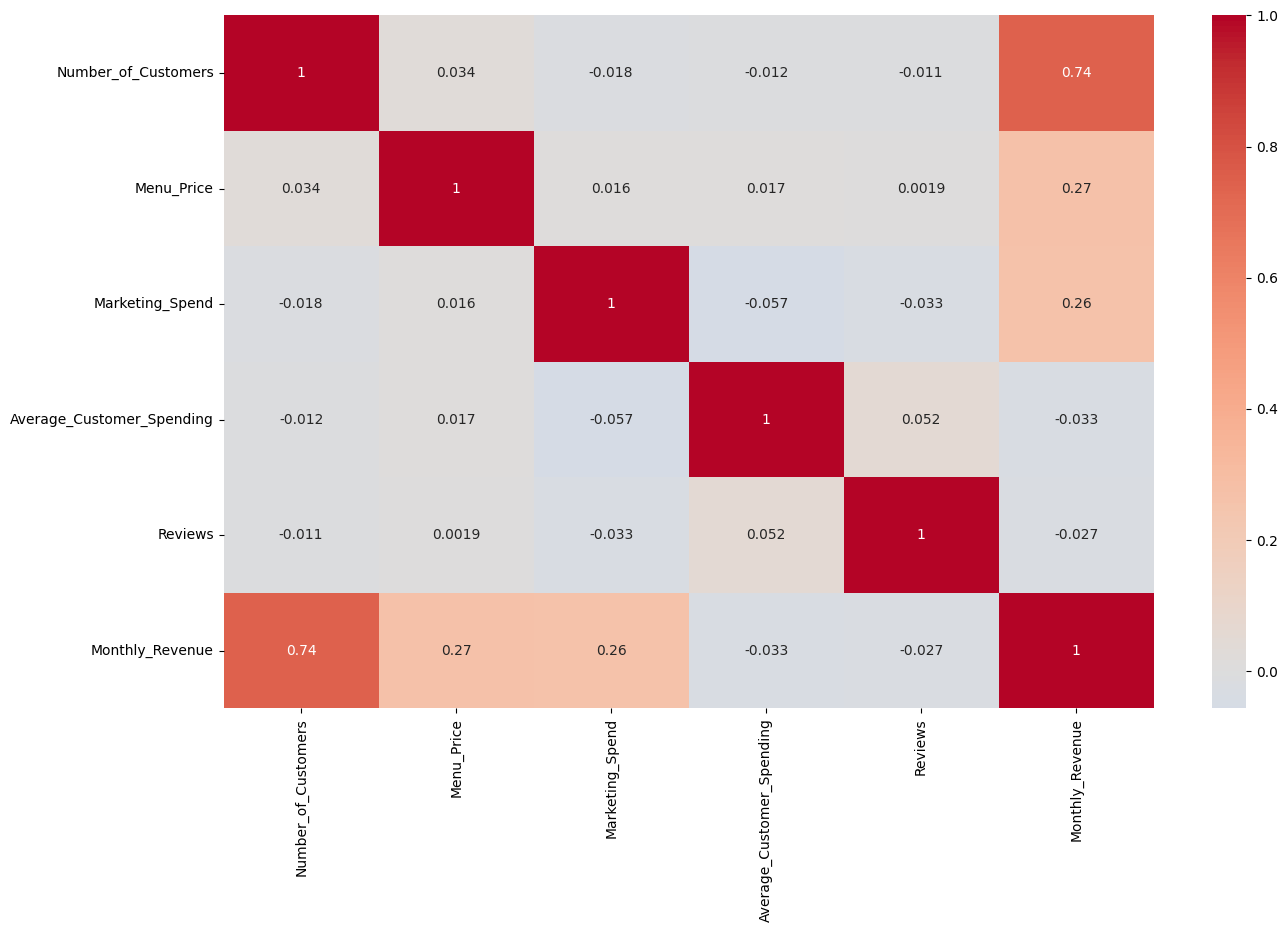

In [ ]:
plt.figure(figsize=(15,9))
sns.heatmap(corr, annot=True,cmap='coolwarm',center=0)

plt.show()

Наиболее тесная линейная связь наблюдается между месячной выручкой и числом посетителей ресторана. Очень слабая линейная связь между месячной выручкой и  средними ценами на меню в ресторане и расходами на маркетинговую деятельность.

Между признаками линейной связи нет.

## Обучение и тестирование моделей ML

### Подготовка данных

Создадим переменные для признаков `X = features` и целевого признака `y = target`


In [ ]:
X = df_clear.drop('Monthly_Revenue',axis=1)
y = df_clear['Monthly_Revenue']

Разобьем данные на обучающую и тестовую выборки в соотношении 80:20 с помощью `train_test_split`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=70)

print('Размерность обучающего набора', X_train.shape)
print('Размерность тестовой выборки', X_test.shape)

Размерность обучающего набора (795, 7)
Размерность тестовой выборки (199, 7)


In [ ]:
# Сделаем копии полученных наборов для выполнения различного рода преобразований
XX_train = X_train.copy()
XX_test = X_test.copy()

Т.к. датасет содержит категориальные признаки, то для применения линейных моделей преобразуем данные методом OHE, введем фиктивные переменные.

Преобразовать категориальные признаки в численные поможет техника
прямого кодирования, или отображения `One-Hot Encoding`.
Техникой OHE категориальные признаки переводятся в численные в два
этапа:
* Для каждого значения признака создаётся новый столбец;
* Если объекту категория подходит, присваивается 1, если нет — 0.
Новые признаки называются дамми-переменными, или дамми-признаками.
Для прямого кодирования в библиотеке pandas есть функция
`pd.get_dummies()`.

Когда данных в избытке, можно угодить в ловушку фиктивных признаков.
Если в таблицу добавились три новых столбца, сильно связанных между
собой, один из них можно не добавлять. Восстановить столбец можно по
оставшимся двум. Так мы не попадём в дамми-ловушку.

Столбец уберём вызовом функции `pd.get_dummies()` с аргументом
`drop_first`. Он удаляет первую колонку и передаётся как `drop_first=True`
или `drop_first=False` (`True` — первый столбец сбрасывается, `False` — не
сбрасывается).

In [ ]:
# создайте списки с количественными и категориальными признаками
cat_col_names = XX_train.select_dtypes(exclude='number').columns.tolist()
num_col_names = XX_train.select_dtypes(include='number').columns.tolist()

    # выберите класс OneHotEncoder() для кодирования
    # задайте sparse значение False, избегайте дамми-ловушки
ohe =OneHotEncoder(drop='first',sparse=False)

    # обучите и преобразуйте категориальные признаки из тренировочной и тестовой выборок
    # для тренировочной выборки выполните действия одной командой
X_train_ohe =ohe.fit_transform(XX_train[cat_col_names])
X_test_ohe =ohe.transform(XX_test[cat_col_names])

    # сохраняем в переменной encoder_col_names список названий новых столбцов
encoder_col_names = ohe.get_feature_names_out()

    # создаём датафрейм из закодированных данных
    # передаём названия столбцов из переменной encoder_col_names
X_train_ohe = pd.DataFrame(X_train_ohe,columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe,columns=encoder_col_names)

    # Для интерпретируемости коэффициентов регрессии проведем стандартизацию количественных переменных
    # выберите класс StandardScaler() для стандартизации
scaler =StandardScaler()

    # обучите и преобразуйте категориальные признаки из тренировочной и тестовой выборок
    # для тренировочной выборки выполните действия одной командой
X_train_scaler =scaler.fit_transform(XX_train[num_col_names])
X_test_scaler =scaler.fit_transform(XX_test[num_col_names])

    # создаём датафрейм из стандартизованных данных
    # передаём названия столбцов из переменной cat_col_names
X_train_scaler = pd.DataFrame(X_train_scaler,columns=num_col_names)
X_test_scaler = pd.DataFrame(X_test_scaler,columns=num_col_names)

    # обнуляем индексы строк перед объединением количественных и категориальных
    # признаков в датафрейм
XX_train =XX_train.reset_index()
XX_test =XX_test.reset_index()

    # объедините количественные и категориальные признаки для тренировочного
    # и тестового датасетов
XX_train = pd.concat([X_train_ohe,X_train_scaler],axis=1)
XX_test = pd.concat([X_test_ohe,X_test_scaler],axis=1)


In [ ]:
print('Размерность обучающего набора', XX_train.shape)
print('Размерность тестовой выборки', XX_test.shape)

Размерность обучающего набора (795, 9)
Размерность тестовой выборки (199, 9)


### Обучение и оценка адекватности моделей ML

#### Linear Regression (Линейная регрессия)

Инициируем класс линейной регрессии `LinearRegression()`, обучим модель методом `fit()` и вычислим метрику качества `R2` на валидационной выборке.

In [ ]:
# Инициируем модель, обучаем на тренировочнй выборке
LR =LinearRegression().fit(XX_train,y_train)

# строим прогноз на тестовой выборке
y_predict =LR.predict(XX_test)

# Вычисляем R2 на валидационной выборке
R2_LR =r2_score(y_test,y_predict)
print('R2 на тестовой выборке', R2_LR)


R2 на тестовой выборке 0.6829896943691209


In [ ]:
LR.coef_

array([-2.41203979, -0.20235867,  1.29258063, 72.86428639, 25.82836802,
       26.63413737, -2.86476755, -1.55545696, -0.39441933])

In [ ]:
# Коэффициенты регрессии
coeff = pd.DataFrame(
     {'Признак' : XX_train.columns,
        'Важность':np.abs(LR.coef_)
     }).sort_values(by ='Важность',  ascending = False)
coeff


Признак   Важность
3        Number_of_Customers  72.864286
5            Marketing_Spend  26.634137
4                 Menu_Price  25.828368
6  Average_Customer_Spending   2.864768
0       Cuisine_Type_Italian   2.412040
7                 Promotions   1.555457
2       Cuisine_Type_Mexican   1.292581
8                    Reviews   0.394419
1      Cuisine_Type_Japanese   0.202359

In [ ]:
# Свободный член (смещение) регрессии
LR.intercept_

273.1729337277844

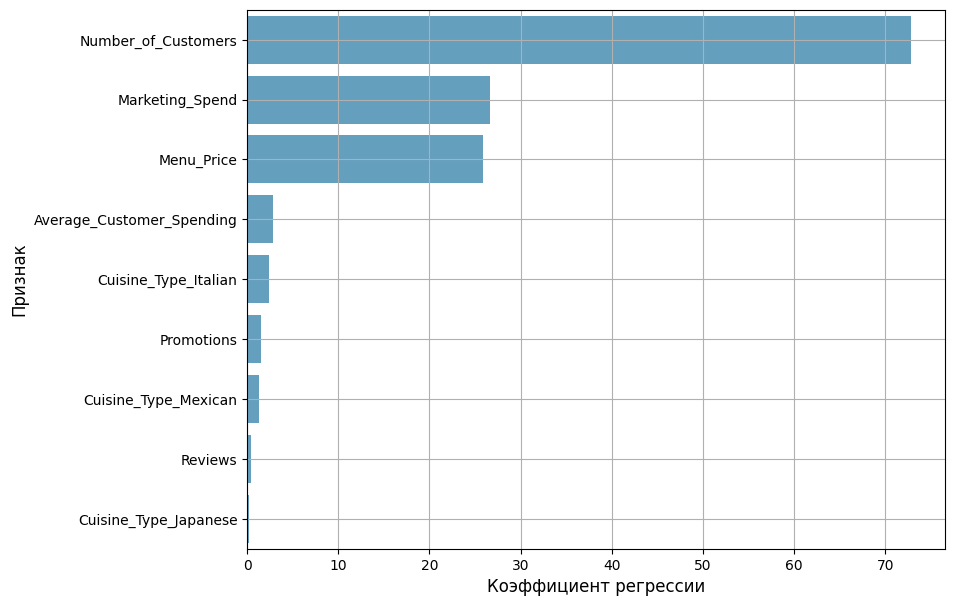

In [ ]:
#Построим график коэффициентов регрессии
# Визуализируем важность признаков
# добавляем размер графика
plt.figure(figsize=(9, 7))
sns.barplot(x=coeff['Важность'],y=coeff['Признак'])

plt.xlabel("Коэффициент регрессии", fontsize = 12)
plt.ylabel("Признак", fontsize = 12)
plt.grid()
plt.show()


#### Отбор признаков на основе статистических тестов

Видно, что не все входные признаки хорошо объясняют целевую переменную. А значит, некоторыми можно пренебречь. Чтобы отобрать признаки, используем `SelectKBest` несколько раз с помощью цикла и определим, при каком количестве признаков коэффициент детерминации будет наибольшим. Для линейной регрессии лучше использовать статистический тест `f_regression`, поскольку оцениваем линейное влияние входных признаков на целевой.

In [ ]:
r2 = []
for i in range(len(XX_train.columns)):
    # объявляем селектор
    # он будет подбирать разное количество признаков за счёт цикла
    selector =SelectKBest( f_regression,k=i+1 )
    selector.fit(XX_train,y_train)

        # сохраняем названия признаков в переменную features_names
    features_names =selector.get_feature_names_out()

    # Отбираем для обучения k признаков
    X_train_new =XX_train[list(features_names)]
    X_test_new =XX_test[list(features_names)]

    # инициализируем и обучаем модель
    model =LinearRegression().fit(X_train_new,y_train)

    R2_new =r2_score(y_test,model.predict(X_test_new))


    r2.append(R2_new)

    print('Количество признаков', i+1, 'R2 =', R2_new)

Количество признаков 1 R2 = 0.5947717680844526
Количество признаков 2 R2 = 0.6133008276233649
Количество признаков 3 R2 = 0.6857483900817114
Количество признаков 4 R2 = 0.6824161395941557
Количество признаков 5 R2 = 0.6821415649188152
Количество признаков 6 R2 = 0.6822443932721758
Количество признаков 7 R2 = 0.6824039883825013
Количество признаков 8 R2 = 0.6826399195218433
Количество признаков 9 R2 = 0.6829896943691209


При 3 признаках модель резко прирастает в качестве — почти на 7%! Наибольшее значение коэффициент детерминации имеет при 3 признаках. Выясним, какие признаки отобрала линейная регрессия.

In [ ]:
selector =SelectKBest(f_regression,k=3)
selector.fit(XX_train,y_train)

features_names =selector.get_feature_names_out()
features_names


array(['Number_of_Customers', 'Menu_Price', 'Marketing_Spend'],
      dtype=object)

Построим модель линейной регрессии по наиболее значимым 3-м признакам.

In [ ]:
LR_new = LinearRegression().fit(XX_train[list(features_names)],y_train)

# строим прогноз на тестовой выборке
y_predict =LR_new.predict(XX_test[list(features_names)])

# Вычисляем R2 на валидационной выборке
R2_LR_new =r2_score(y_test,y_predict)
print('R2 на тестовой выборке', R2_LR_new)


R2 на тестовой выборке 0.6857483900817114


Для сравнения надо попробовать другие методы отбора признаков — например, `L1`-регуляризацию.

#### Lasso Regression (Лассо регрессия)



In [ ]:
# Инициируем модель, обучаем на тренировочнй выборке
LassoR =Lasso().fit(XX_train,y_train)

# строим прогноз на тестовой выборке
y_predict =LassoR.predict(XX_test)

# Вычисляем R2 на валидационной выборке
R2_LassoR =r2_score(y_test,y_predict)
print('R2 на тестовой выборке', R2_LassoR)

R2 на тестовой выборке 0.6826492646797035


In [ ]:
# Коэффициенты регрессии
coeff_Lasso = pd.DataFrame(
     {'Признак' : XX_train.columns,
        'Важность':LassoR.coef_
     }).sort_values(by ='Важность',  ascending = False)
coeff_Lasso




Признак   Важность
3        Number_of_Customers  71.821145
5            Marketing_Spend  25.647148
4                 Menu_Price  24.919126
0       Cuisine_Type_Italian  -0.000000
1      Cuisine_Type_Japanese   0.000000
2       Cuisine_Type_Mexican   0.000000
8                    Reviews  -0.000000
7                 Promotions  -0.495330
6  Average_Customer_Spending  -2.005067

In [ ]:
# Свободный член (смещение) регрессии
LassoR.intercept_

272.8751995193373

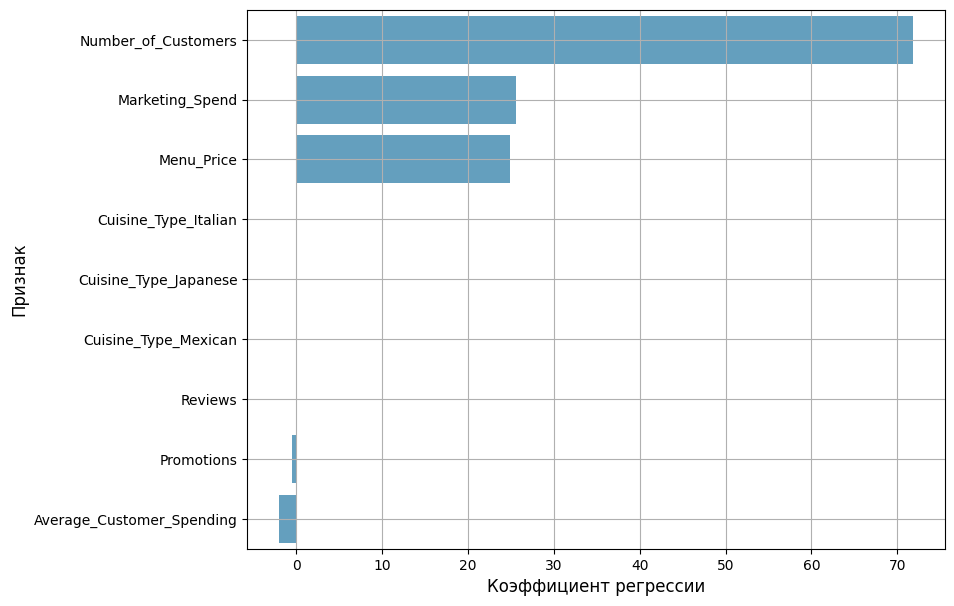

In [ ]:
#Построим график коэффициентов регрессии
# Визуализируем важность признаков
# добавляем размер графика
plt.figure(figsize=(9, 7))
sns.barplot(x=coeff_Lasso['Важность'],y=coeff_Lasso['Признак'])

plt.xlabel("Коэффициент регрессии", fontsize = 12)
plt.ylabel("Признак", fontsize = 12)
plt.grid()
plt.show()

In [ ]:
Results = pd.DataFrame({'Algorithm': ['Linear Regression', 'Lasso Regression'],
                        'R2 score test': [round(R2_LR, 3), round(R2_LassoR, 3)]
})
Results

Algorithm  R2 score test
0  Linear Regression          0.683
1   Lasso Regression          0.683

Видим, что для модели линейной регрессии при использовании `L1`-регуляризации метрика `R2` на тестовой выборке остается меньше 0.7.


#### Полиномиальная регрессия

Линейная регрессия улавливает только линейные зависимости, поэтому её можно улучшить, добавив в признаковое описание полиномиальные признаки с помощью полиномизации.

In [ ]:
poly = PolynomialFeatures(2)

X_train_poly =poly.fit_transform(XX_train[num_col_names])
X_test_poly =poly.transform(XX_test[num_col_names])

# стандартизация количественных признаков
# создаём датафрейм из стандартизованных данных
# передаём названия столбцов из poly
X_train_scalled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns=poly.get_feature_names_out())
X_test_scalled =  pd.DataFrame(scaler.transform(X_test_poly),columns=poly.get_feature_names_out())

    # обнуляем индексы строк перед объединением количественных и категориальных
    # признаков в датафрейм
X_train_poly =pd.DataFrame()
X_test_poly =pd.DataFrame()

    # объедините количественные и категориальные признаки для тренировочного
    # и тестового датасетов
X_train_poly = pd.concat([X_train_ohe,X_train_scalled], axis=1)
X_test_poly = pd.concat([X_test_ohe,X_test_scalled],axis=1)


In [ ]:
# Инициируем модель линейной регрессии, обучаем на тренировочнй выборке
LR_poly = LinearRegression().fit(X_train_poly,y_train)

# строим прогноз на тестовой выборке
y_predict =LR_poly.predict(X_test_poly)

# Вычисляем R2 на валидационной выборке
R2_LR_poly =r2_score(y_test,y_predict)
print('R2 на тестовой выборке', R2_LR_poly)

R2 на тестовой выборке -3.1015530063376025e+24


In [ ]:
# Инициируем модель лассо-регрессии, обучаем на тренировочнй выборке
Lasso_poly = Lasso().fit(X_train_poly,y_train)

# строим прогноз на тестовой выборке
y_predict =Lasso_poly.predict(X_test_poly)

# Вычисляем R2 на валидационной выборке
R2_Lasso_poly =r2_score(y_test,y_predict)
print('R2 на тестовой выборке', R2_Lasso_poly)

R2 на тестовой выборке 0.6813676818968568


In [ ]:
# Коэффициенты регрессии
coeff = pd.DataFrame(
     {'Признак' : X_train_poly.columns,
        'Важность':Lasso_poly.coef_
     }).sort_values(by ='Важность',  ascending = False)
coeff


Признак   Важность
4                             Number_of_Customers  71.855998
6                                 Marketing_Spend  25.544067
5                                      Menu_Price  24.917124
12            Number_of_Customers Marketing_Spend   3.769357
27              Average_Customer_Spending Reviews   1.975125
11                 Number_of_Customers Menu_Price   1.752676
23                     Marketing_Spend Promotions   0.747571
15                    Number_of_Customers Reviews   0.515344
18           Menu_Price Average_Customer_Spending   0.477815
1                           Cuisine_Type_Japanese  -0.000000
29                             Promotions Reviews  -0.000000
25                    Average_Customer_Spending^2   0.000000
22      Marketing_Spend Average_Customer_Spending  -0.000000
21                              Marketing_Spend^2   0.000000
16                                   Menu_Price^2   0.000000
0                            Cuisine_Type_Italian  -0.000000
13  Number_of_Customers Average_Customer_Spending  -0.000000
9                                         Reviews  -0.000000
3                                               1   0.000000
2                            Cuisine_Type_Mexican   0.000000
20                             Menu_Price Reviews  -0.152376
17                     Menu_Price Marketing_Spend  -0.163556
24                        Marketing_Spend Reviews  -0.168333
28                                   Promotions^2  -0.203804
19                          Menu_Price Promotions  -0.485010
8                                      Promotions  -0.572154
26           Average_Customer_Spending Promotions  -0.593330
14                 Number_of_Customers Promotions  -1.032778
7                       Average_Customer_Spending  -1.543760
30                                      Reviews^2  -1.735664
10                          Number_of_Customers^2  -2.858402

In [ ]:
Results = pd.DataFrame({'Algorithm': ['Linear Regression', 'Lasso Regression', 'Linear Regression F-test', 'Linear Regression poly', 'Lasso Regression poly'],
                        'R2 score test': [round(R2_LR, 3), round(R2_LassoR, 3), round(R2_LR_new, 3), round(R2_LR_poly, 3), round(R2_Lasso_poly, 3)]
})
Results

Algorithm  R2 score test
0         Linear Regression   6.830000e-01
1          Lasso Regression   6.830000e-01
2  Linear Regression F-test   6.860000e-01
3    Linear Regression poly  -3.101553e+24
4     Lasso Regression poly   6.810000e-01

Как видим, лучший результат показывает модель `Lasso`-регрессии и модель линейной регрессии с отобранными тремя признаками.

#### Вычисление основных метрик регрессии и исследование остатков модели

In [ ]:
# Построим прогноз на тестовом наборе данных модели линейной регрессии и вычислим ключевые метрики регрессии
model_pred =LR_new.predict(XX_test[list(features_names)])
model_pred

array([230.44067103, 311.37568948, 139.76103013, 274.89120184,
       295.78532636, 330.99623033, 203.48791022, 209.7258118 ,
       391.41378797, 290.06624618, 215.37907558, 411.57365231,
       224.94228604, 180.90698062, 274.01629111, 233.69386506,
       162.92379714, 288.31460762, 357.19697031, 273.25609479,
       178.06802204, 279.79764404, 397.65824262, 347.69311662,
       188.96486713, 112.89794857, 318.08316483, 276.99059155,
       190.64369966, 468.73943229, 280.5956221 , 284.52065056,
       315.87424312, 237.08923291, 263.11245503, 211.47488861,
       305.27912252,  84.46713306, 139.46325591, 270.14620355,
       445.67418765, 189.83508835, 309.61872286, 359.66421254,
       403.00308051, 217.51539678, 380.05170649, 194.00940259,
       359.55961974, 306.2942433 , 295.07387037, 409.10577042,
       170.46075797, 392.07281293, 196.65796755, 271.19349143,
       161.86247438, 373.21486219, 273.44107947, 340.1926081 ,
       169.56683415, 273.71532751, 234.86721402, 242.22

In [ ]:
# Вычислим основные метрики регрессии на тестовом множестве
print("R2 на тестовой выборке:", r2_score(y_test,model_pred))
print("MAE на тестовой выборке:",mean_absolute_error(y_test,model_pred) )
print("MAPE на тестовой выборке:",mean_absolute_percentage_error(y_test,model_pred) )
print("MSE на тестовой выборке:", mean_squared_error(y_test,model_pred))
print("RMSE на тестовой выборке:",mean_squared_error(y_test,model_pred,squared=False) )

R2 на тестовой выборке: 0.6857483900817114
MAE на тестовой выборке: 48.37675934264659
MAPE на тестовой выборке: 0.48900434526644093
MSE на тестовой выборке: 3735.5038752808578
RMSE на тестовой выборке: 61.118768600822264


На тестовом наборе коэффициент детерминации $R^2$ = 0.69, что свидетельствует о не достаточно хорошем качестве прогнозирования.

Построим график прогноза и фактических данных в виде диаграммы рассеяния.

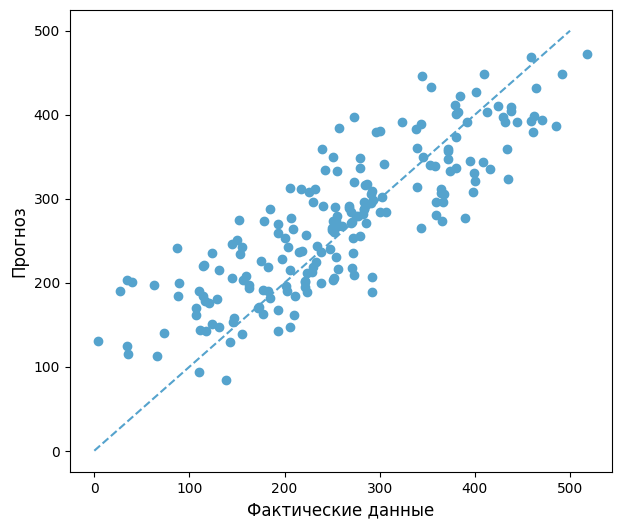

In [ ]:
plt.figure(figsize = (7,6))
plt.scatter(x=y_test,y=model_pred)


plt.plot([0, 500], [0, 500], linestyle='--')
plt.xlabel('Фактические данные', fontsize = 12)
plt.ylabel('Прогноз', fontsize = 12)
plt.show()


Изучим остатки регрессии

In [ ]:
residual = y_test - model_pred

# Изучим числовые характеристики остатков
residual.describe()

count    199.000000
mean     -14.867174
std       59.432490
min     -168.911168
25%      -54.340866
50%      -10.458350
75%       24.358688
max      112.107924
Name: Monthly_Revenue, dtype: float64

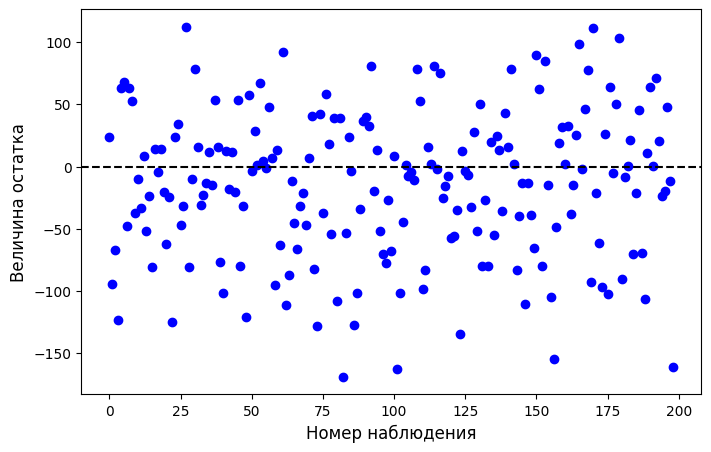

In [ ]:
plt.figure(figsize = (8,5))

plt.scatter(x = np.arange(len(residual)), y = residual, color = 'blue')
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.xlabel('Номер наблюдения', fontsize = 12)
plt.ylabel('Величина остатка', fontsize = 12)
plt.show()

<Figure size 800x500 with 0 Axes>

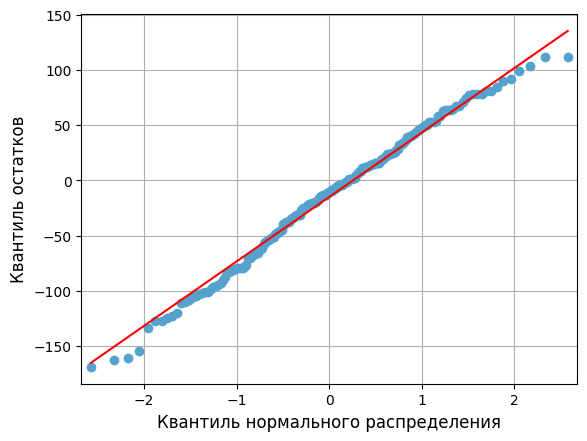

In [ ]:
# Построим график QQ
plt.figure(figsize = (8,5))
sm.qqplot(residual,line='q')
plt.grid()
plt.xlabel('Квантиль нормального распределения', fontsize = 12)
plt.ylabel('Квантиль остатков', fontsize = 12)

plt.show()

In [ ]:
# Проверим гипотезу о нормальном распределении
stat_shapiro(residual)

Alpha:  0.05
P-value: 0.181
Нет оснований отвергнуть нулевую гипотезу, распределение нормально


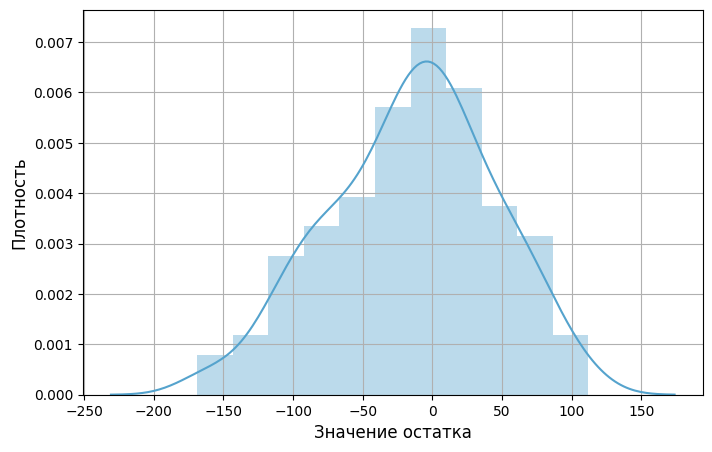

In [ ]:
# Построим график плотности распределения вероятностей остатков
plt.figure(figsize = (8,5))
sns.distplot(residual, hist=True)

plt.grid()
plt.xlabel('Значение остатка', fontsize = 12)
plt.ylabel('Плотность', fontsize = 12)

plt.show()

### Проверка модели на адекватность. Оценка константной моделью

In [ ]:
DummyModel =DummyRegressor().fit(XX_train,y_train)
r2_dummy =r2_score(y_test,DummyModel.predict(XX_test))
print('R2 = ', r2_dummy)

R2 =  -0.01859452771611947


Значение метрики $R^2$ для константной модели на тестовой выборке отрицательна, что свидетельствует о плохом качестве константной модели. Таким образом, построенную модель регрессии можем считать адекватной.